In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from tpot import TPOTClassifier
import matplotlib.pyplot as plt

In [5]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class_mixed.parquet")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
print(pd_train["label"].value_counts())
pd_train.head()

(1221, 16095)
label
1    723
0    498
Name: count, dtype: int64


,Smiles,Liver,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
index,,,,,,,,,,,,,,,,,,,,,
998,N1C[C@H]2C[C@H](c3c2cc2nccnc2c3)C1,NonHepatotoxicity,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,CCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)I)O)I,Hepatotoxicity,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
283,O[C@@]12[C@H]3[C@@H]([C@@]4([C@H](CC3)C[C@@H](...,NonHepatotoxicity,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1082,O=C1[C@@]2(C(C3C([C@@]4(C(=CC3)C[C@@H](O)CC4)C...,Hepatotoxicity,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
122,O[C@@]12[C@@]3(CCN([C@H]1Cc1c3cc(O)cc1)CC1CCC1...,NonHepatotoxicity,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class_mixed.parquet")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
print(pd_test["label"].value_counts())
pd_test.head()

(306, 16095)
label
1    181
0    125
Name: count, dtype: int64


,Smiles,Liver,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,...,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X,label
index,,,,,,,,,,,,,,,,,,,,,
724,Clc1c(cc([C@]2(O)CCN(CC2)CCC[C@@H](c2ccc(F)cc2...,NonHepatotoxicity,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82,CN(C)N/N=C\1/C(=NC=N1)C(=O)N,Hepatotoxicity,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
384,F[C@]12[C@H]([C@H]3[C@@]([C@](O)(CC3)C(=O)CO)(...,NonHepatotoxicity,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
627,O=C(N1[C@@H](Cc2c(C1)cc(OC)c(OC)c2)C(=O)O)[C@@...,Hepatotoxicity,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
896,Oc1cc([C@@H]([C@H](CN(C)C)C)CC)ccc1,Hepatotoxicity,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
X_train = pd_train.drop(columns=["Liver", "Smiles", "label"])
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
y_train = pd_train["label"]

X_test = pd_test[X_train.columns]
X_test = X_test.fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0)
y_test = pd_test["label"]

# PCA optimization

In [9]:
# List to store AUC scores for different PCA dimensions
# dimensions = range(100, 500, 100)  # Check PCA dimensions from 1 to 10
dimensions = [10, 20, 50, 100, 200, 300, 500, 800, 1000, 1200]
dimensions = [10, 20, 50, 100, 200, 500, 1000]
tpot_results = []  # List to store results

# Loop over different numbers of PCA components
for n_components in dimensions:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Set up TPOT with basic configuration
    tpot = TPOTClassifier(
        generations=5,
        population_size=20,
        verbosity=2,
        scoring="roc_auc",  # AUC
        random_state=42,
        n_jobs=16,  # Use 4 cores
    )

    # Fit TPOT on the PCA-transformed data
    tpot.fit(X_train_pca, y_train)

    # Access the best pipeline directly after fitting
    best_pipeline = tpot.fitted_pipeline_

    # Check if the model has predict_proba
    if hasattr(best_pipeline, "predict_proba"):
        y_pred = best_pipeline.predict_proba(X_test_pca)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
    else:
        # Fallback to accuracy if predict_proba is unavailable
        y_pred = best_pipeline.predict(X_test_pca)
        auc = accuracy_score(
            y_test, y_pred
        )  # Substitute with accuracy if AUC can't be calculated

    y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Extract model name and parameters
    model_name = type(
        best_pipeline.steps[-1][1]
    ).__name__  # Name of the final estimator
    model_params = best_pipeline.steps[-1][
        1
    ].get_params()  # Params of the final estimator

    # Append results to list
    result = {
        "Best model": best_pipeline,
        "PCA Components": n_components,
        "Model Name": model_name,
        "Parameters": model_params,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    tpot_results.append(result)

    print(result)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7413617946708464

Generation 2 - Current best internal CV score: 0.7413617946708464

Generation 3 - Current best internal CV score: 0.7450952281435039

Generation 4 - Current best internal CV score: 0.7450952281435039

Generation 5 - Current best internal CV score: 0.7548622082897947

Best pipeline: KNeighborsClassifier(MaxAbsScaler(input_matrix), n_neighbors=13, p=1, weights=distance)
{'Best model': Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=13, p=1,
                                      weights='distance'))]), 'PCA Components': 10, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}, 'AUC': 0.7824972375690609, 'Precision': 0.7475247524752475, 'Recall': 0.8342541436464088, 'Sensitivity': 0.8

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7481069096133751

Generation 2 - Current best internal CV score: 0.7481069096133751

Generation 3 - Current best internal CV score: 0.7538325670498085

Generation 4 - Current best internal CV score: 0.7574265499825846

Generation 5 - Current best internal CV score: 0.7574265499825846

Best pipeline: GradientBoostingClassifier(StandardScaler(input_matrix), learning_rate=0.1, max_depth=9, max_features=0.05, min_samples_leaf=6, min_samples_split=3, n_estimators=100, subsample=0.7500000000000001)
{'Best model': Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=9, max_features=0.05,
                                            min_samples_leaf=6,
                                            min_samples_split=3,
                                            random_state=42,
                                            subsample=0.75000000000000

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7715384360849878

Generation 2 - Current best internal CV score: 0.7715384360849878

Generation 3 - Current best internal CV score: 0.7715384360849878

Generation 4 - Current best internal CV score: 0.7715384360849878

Generation 5 - Current best internal CV score: 0.7755914925113201

Best pipeline: ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=10, min_samples_split=11, n_estimators=100)
{'Best model': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.9500000000000001,
                                      min_samples_leaf=10, min_samples_split=11,
                                      random_state=42))]), 'PCA Components': 50, 'Model Name': 'ExtraTreesClassifier', 'Param

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7710897640195055

Generation 2 - Current best internal CV score: 0.7859932471264368

Generation 3 - Current best internal CV score: 0.7877260013932428

Generation 4 - Current best internal CV score: 0.7877555468477883

Generation 5 - Current best internal CV score: 0.7895384186694532

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=6, min_samples_split=5, n_estimators=100)
{'Best model': Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy',
                                      max_features=0.6500000000000001,
                                      min_samples_leaf=6, min_samples_split=5,
                                      random_state=42))]), 'PCA Components': 100, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'm

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7751221177290143

Generation 2 - Current best internal CV score: 0.7792091866945314

Generation 3 - Current best internal CV score: 0.7792091866945314

Generation 4 - Current best internal CV score: 0.7792091866945314

Generation 5 - Current best internal CV score: 0.7838547718564961

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=5, min_samples_split=19, n_estimators=100)
{'Best model': Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy',
                                      max_features=0.6500000000000001,
                                      min_samples_leaf=5, min_samples_split=19,
                                      random_state=42))]), 'PCA Components': 200, 'Model Name': 'ExtraTreesClassifier', 'Parameters': {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7649296760710554

Generation 2 - Current best internal CV score: 0.7649296760710554

Generation 3 - Current best internal CV score: 0.7649296760710554

Generation 4 - Current best internal CV score: 0.7649296760710554

Generation 5 - Current best internal CV score: 0.7649296760710554

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]), 'PCA Components': 500, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, 'AUC': 0.7633149171270718, 'Precision': 0.791907514450867, 'Recall': 0.7569060773480663, 'Sensitivity': 0.7569060773480663, 'Specificity': 0.712}


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7632066048415186

Generation 2 - Current best internal CV score: 0.7632066048415186

Generation 3 - Current best internal CV score: 0.7632066048415186

Generation 4 - Current best internal CV score: 0.7632066048415186

Generation 5 - Current best internal CV score: 0.7632066048415186

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=23, p=2, weights=distance)
{'Best model': Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=23, weights='distance'))]), 'PCA Components': 1000, 'Model Name': 'KNeighborsClassifier', 'Parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 23, 'p': 2, 'weights': 'distance'}, 'AUC': 0.7830055248618786, 'Precision': 0.75, 'Recall': 0.8121546961325967, 'Sensitivity': 0.8121546961325967, 'Specificity': 0.608}


In [10]:
# Convert results to DataFrame
tpot_df = pd.DataFrame(tpot_results)
tpot_df

,Best model,PCA Components,Model Name,Parameters,AUC,Precision,Recall,Sensitivity,Specificity
0,"(MaxAbsScaler(), KNeighborsClassifier(n_neighb...",10,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.782497,0.747525,0.834254,0.834254,0.592
1,"(StandardScaler(), ([DecisionTreeRegressor(cri...",20,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.792309,0.762887,0.817680,0.817680,0.632
2,"(PolynomialFeatures(include_bias=False), (Extr...",50,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.807691,0.750000,0.878453,0.878453,0.576
3,"((ExtraTreeClassifier(criterion='entropy', max...",100,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.792000,0.766169,0.850829,0.850829,0.624
4,"((ExtraTreeClassifier(criterion='entropy', max...",200,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.793812,0.740385,0.850829,0.850829,0.568
5,"(KNeighborsClassifier(n_neighbors=3, p=1, weig...",500,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.763315,0.791908,0.756906,0.756906,0.712
6,"(KNeighborsClassifier(n_neighbors=23, weights=...",1000,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.783006,0.750000,0.812155,0.812155,0.608


In [11]:
import pandas as pd
import joblib

# Save results using Joblib
joblib.dump(tpot_results, "models/tpot_results_mixed.joblib")
print("Results saved to tpot_results_mixed.joblib")

# # Optionally, load the results back
# loaded_results = joblib.load("models/tpot_results_mixed.joblib")

# # Convert results to DataFrame
# tpot_df = pd.DataFrame(loaded_results)
# tpot_df

Results saved to tpot_results_mixed.joblib


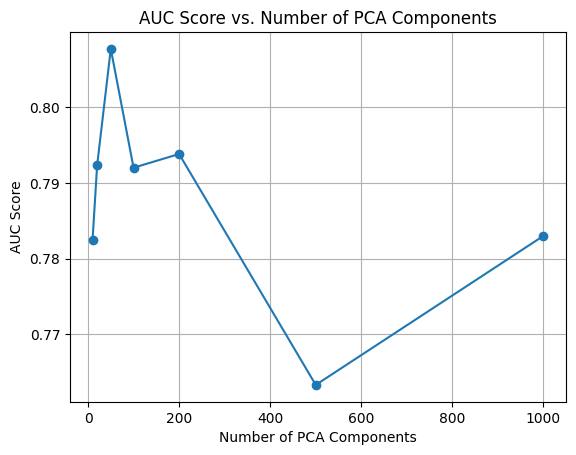

In [12]:
# Plot AUC scores against the number of PCA components
plt.plot(tpot_df["PCA Components"], tpot_df["AUC"], marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("AUC Score")
plt.title("AUC Score vs. Number of PCA Components")
plt.grid()
plt.show()